# 카메라 스티커앱 만들기

## 목표

* 카메라앱 만들기를 통해 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근 기술을 다룬다.

* 간단한 스티커부터 시작해서 각도 변화가 가능하고 거리 변화에 강건한 스티커까지 만들 수 있다.

* 얼굴인식 카메라의 흐름을 이해할 수 있다.

* dlib 라이브러리를 사용할 수 있다.

* 이미지 배열의 인덱싱 예외 처리를 할 수 있다.

스티커를 세밀하고 자연스럽게 적용하기 위해서는 눈, 코, 입, 귀와 같은 얼굴 각각의 위치를 아는 것이 중요하다. 이들을 찾아내는 기술을 랜드마크(landmark)또는 조정(alignment)이라고 한다. 조금 더 큰 범위로는 keypoint detection 이라고 부른다.

1. 얼굴이 포함된 사진을 준비한다.  
2. 사진으로무터 얼굴 영역(face landmark)를 찾아낸다. (landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾아야 한다.)  
3. 찾아진 영역으로부터 머리에 왕관 스티커를 붙여넣는다.

### 1. 사진 준비하기

In [1]:
# 관련 패키지 설치
# pip install opencv-python
# pip install cmake
# pip install dlib

In [2]:
# 필요 라이브러리 import
import cv2
import matplotlib.pyplot as plt
import numpy as np

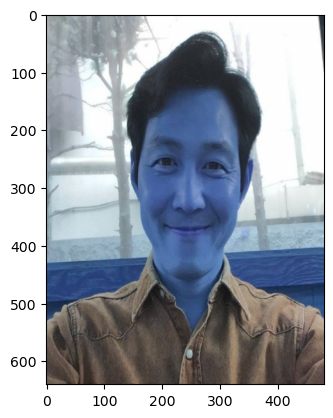

In [3]:
# opencv로 이미지 읽어오기
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (480, 640)) # 4:3비율
img_show = img_bgr.copy() # 출력이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

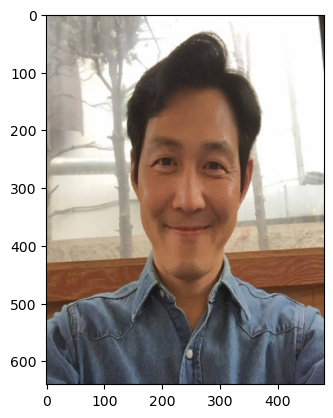

In [4]:
# plt.imshow 이전에 RGB 이미지로 변경
# opencv는 BGR사용 -> RGB변경 필요
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 2. 얼굴 검출(Face Detection)  
Object Detection 기술을 이용해서 얼굴의 위치 찾기.  
dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는다.

rectangles[[(142, 192) (365, 415)]]


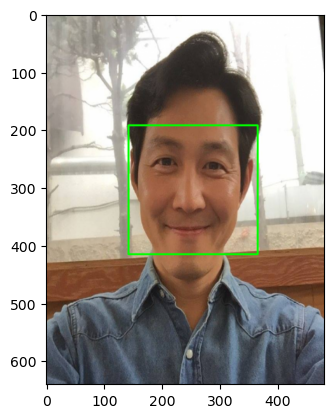

In [7]:
# hog detecter 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (image, num of img pyramid)

# 찾은 얼굴영역 출력
print(dlib_rects) # 찾은 얼굴영역 좌표
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    # cv2.rectangle(img, 시작점좌표(x,y), 종료점좌표(x,y), 색상, 선두께, 선종류)
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 3. 얼굴 랜드마크(Face Landmark)  
face landmark는 detection의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지를 이용함.  
Object keypoint estimation 알고리즘 : 객체 내부의 점을 찾는 기술  
1) top-down : bounding box를 찾고, box내부의 keypoint예측  
2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고, point관계를 이용해 군집화해 box 생성

In [8]:
# Dlib 제공 모델 사용
wget 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

SyntaxError: invalid syntax (<ipython-input-8-01d9d58fdd5a>, line 2)

In [13]:
# landmark 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_'
landmark_predictor = dlib.shape_predictor(model_path)

68


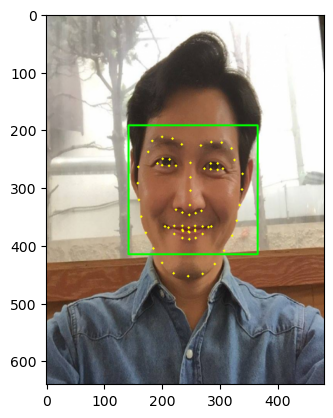

In [15]:
# landmark 찾기
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p:(p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

# landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0,255,255), -1) # yellow
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()    

### 4. 스티커 적용하기  

적절한 랜드마크를 기준으로 하여 이미지 구현함

In [16]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # nose center index :30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2 #나누기 연산 후 소수점 이하의 수를 버리고, 정수 부분의 수만 구함
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    

(248, 330)
(x,y) : (248,218)
(w,h) : (224,224)


In [34]:
# 스티커 이미지 read
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

# 스티커 이미지 좌표
refined_x = x- w //2 # left
refined_y = y -h # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(224, 224, 3)
(x,y) : (136,-6)
(218, 224, 3)
(x,y) : (136,0)


In [ ]:
# 원본 이미지에 스티커를 적용합니다.
# 아래로 하면 안되고 
# sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
#     np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

# print(img_sticker.shape[0])

# 이걸로 하면 된다 
# sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
#     np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

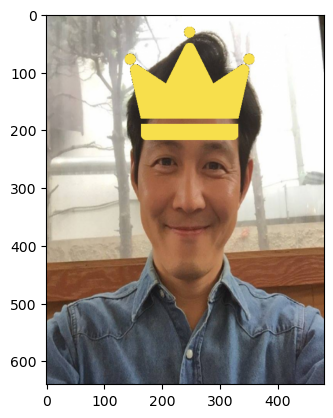

In [36]:
# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]=\
     np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

# # 결과 이미지 출력
# plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.show()

# bounding box 제거 후 이미지
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 실습 notebook과 합치기

이미지 처리 결과로는 왕관이 잘리지 않았는데, 이미지의 y값이 초기에 -여서 에러가 발생했다. 
코를 중심으로 눈썹위에 왕관이 잘 올라갔다.